# This notebook is to model the Sun plus subgiant and red-giant stars in M67.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob
from scipy.optimize import curve_fit
import re
import math
import os
import matplotlib.pyplot #
from astropy.io import ascii

# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


# define a couple of functions 

In [2]:
def mle(model, obs, obs_e):
    lk = np.exp( 0.0 - (model - obs)**2.0/2.0/obs_e**2.0 )
    return lk

def linear(x, a, b):
    return a * x + b

def ball_two_term(X, a1, a3):
    nu0, nu, inertia = X
    return nu0 + (a1*nu**(-1.0) + a3*nu**3.0)/inertia

def ball_cubic_term(X, a3):
    nu0, nu, inertia = X
    return nu0 + a3*nu**3.0/inertia

def ball_inverse_term(X, a1):
    nu0, nu, inertia = X
    return nu0 + a1*nu**(-1.0)/inertia
    
    
def kb95(X, a, b):
    x1, x2 = X
    return x1 - a*x2**b

def correct_sc_kb95(obs_freq, model_freq, nu_max, a, b):
    new_model_freq = model_freq + a*(model_freq/nu_max)**b
    return new_model_freq

def surface_correction(obs_freq, obs_freq_e, model_freq, model_inertia, nu_max, sc_method,given_a3 = 9999.0):
    if (sc_method == 'kb95'):
        #kb 95 nu_obs - nu_model = a*(nu_obs/nu_max)**b        
        popt, pcov = curve_fit(kb95, (obs_freq, obs_freq/nu_max), model_freq)
        a, b = popt
        a_e, b_e = pcov
        model_freq_c = correct_sc_kb95(obs_freq, model_freq, nu_max, a, b)
    if (sc_method == 'bg2'):
        #Ball&Gizon 2 terms: obs - model = (a1*(nu/nu_ac)**(-1) + a3*(nu/nu_ac)**(3))/inertia
        # model = obs - (a1*(nu/nu_ac)**(-1) + a3*(nu/nu_ac)**(3))/inertia
        popt, pcov = curve_fit(ball_two_term, (model_freq, model_freq/1.6/nu_max, model_inertia), obs_freq, sigma = obs_freq_e)
        a, b = popt
        a_e, b_e = pcov
        model_freq_c = ball_two_term((model_freq,model_freq/1.6/nu_max, model_inertia), a, b)
    if (sc_method == 'bg1'):
        #Ball&Gizon cubic term: obs - model = (a3*(nu/nu_ac)**(3))/inertia
        # model = obs - (a3*(nu/nu_ac)**(3))/inertia
        popt, pcov = curve_fit(ball_cubic_term, (model_freq, model_freq/1.6/nu_max, model_inertia), obs_freq, sigma = obs_freq_e)
        b = popt
        b_e = pcov
        model_freq_c = ball_cubic_term((model_freq,model_freq/1.6/nu_max, model_inertia), b)
        a = 0
    if ((sc_method == 'bg2x') & (given_a3 < 9999.0)):
        #Ball&Gizon cubic term: obs - model = (a3*(nu/nu_ac)**(3))/inertia
        model_freq1 = model_freq + (given_a3*(model_freq/1.6/nu_max)**3)/model_inertia
        popt, pcov = curve_fit(ball_inverse_term, (model_freq1, model_freq/1.6/nu_max, model_inertia), obs_freq, sigma = obs_freq_e)
        a = popt
        a_e = pcov
        b = given_a3
        model_freq_c = ball_two_term((model_freq,model_freq/1.6/nu_max, model_inertia), a, b)

    return a, b, model_freq_c  

def seismo_lk(obs_freq,obs_freq_e,mode_freq, n):
    chi2 = np.mean(((obs_freq - mode_freq)**2.0/2.0/obs_freq_e**2.0))
    lk = math.exp(0.0 - chi2)
    dif = np.median(np.abs(obs_freq - mode_freq))
    return lk, dif

def get_chi2(model, obs, obs_e):
    chi2 = (model - obs)**2.0/2.0/obs_e**2.0
    return chi2

def fit_two_sets(obs, obs_e, model, model_x = None):
    find_model = np.full(len(obs), 0.0)
    find_model_x = np.full(len(obs), 0.0)
    chi2 = np.full(len(obs), 9999.0)
    for i in range(len(obs)):
        nuse = np.argmin(np.abs(model - obs[i]))
        find_model[i] = model[nuse]
        find_model_x[i] = model_x[nuse]
        chi2[i] = get_chi2(model[nuse], obs[i], obs_e[i])
    return find_model, find_model_x, chi2


def prob(para, lk, start, end, binsize, shift):
    n = int((end - start + shift)/binsize)
    x = np.zeros(n)
    y = np.zeros(n)
    for i in range(n):
        x[i] = start + shift + i*binsize + 0.5*binsize
        yindex = ((para >= (start + shift + i*binsize)) &
                          (para < (start + shift + (i+1)*binsize))
                         )
        y[i] = np.sum(lk[yindex])
    return x, y

def gaus(x):
    return a*math.exp(-(x-mu)**2/(2*sigma**2))

def power_law(X, a, b, c, d, e, f):
    x1, x2, x3, x4, x5, x6 = X
    return -x1**a*x2**b*x3**c*x4**d*x5**e*x6**f

def prob_dist(df, xcolumn, ycolumn, start, end, size, ax):
    
    #n1 = df.evol_stage ==2
    #n2 = df.evol_stage ==3
    
    nbins = int((end - start)/size)

    px0, py0 = prob(df[xcolumn], df[ycolumn], start, end, size, 0.0)
    #px1, py1 = prob(df[n1][xcolumn], df[n1][ycolumn], start, end, size, 0.0)
    #px2, py2 = prob(df[n2][xcolumn], df[n2][ycolumn], start, end, size, 0.0)


    pxs0 = []

    for i in range(len(px0)):
        nn0 = int(py0[i]/np.max(py0)*1000)
        pxs0 = pxs0 + [px0[i]]*nn0
    #pxs1 = []
    #for i in range(len(px1)):
    #    nn1 = int(py1[i]/np.max(py1)*1000)
    #    pxs1 = pxs1 + [px1[i]]*nn1
        
    #pxs2 = []
    #for i in range(len(px2)):        
    #    nn2 = int(py2[i]/np.max(py2)*1000)
    #    pxs2 = pxs2 + [px2[i]]*nn2

    n, bins, patches = ax.hist([pxs0], bins = nbins, range=[start, end], color = ['lightblue'])
    ax.set_xlim(start, end)
    ax.set_ylim(0.0,1220)
    ax.set_yticks([0,200,400,600,800,1000])
    ax.set_yticklabels(['0.0','0.2','0.4','0.6','0.8','1.0'])
    
    pxlow, px, pxhigh = np.percentile(pxs0, (16,50,84))
    
    return px, pxhigh, pxlow

def fit_radial_modes(starset_seismo, obs_nu0, obs_nu0_e, obs_n0, obs_delta_nu,obsnumax,savefig = None):
    nu_0_n_number = [i for i in range(1,41)]
    nu_0_n_text = ['nu_0_%s' % s for s in nu_0_n_number]
    E_0_n_text = ['E_0_%s' % s for s in nu_0_n_number]
    nu_1_n_number = [i for i in range(-1000,41)]
    nu_1_n_text = ['nu_1_%s' % s for s in nu_1_n_number]
    E_1_n_text = ['E_1_%s' % s for s in nu_1_n_number]
    nu_2_n_number = [i for i in range(-1000,41)]
    nu_2_n_text = ['nu_2_%s' % s for s in nu_2_n_number]
    E_2_n_text = ['E_2_%s' % s for s in nu_2_n_number]
    output_freq_header = nu_0_n_text # + nu_1_n_text + nu_2_n_text
    output_E_hearder = E_0_n_text  # + E_1_n_text + E_2_n_text

    ##########################
    all_freq = obs_nu0
    all_freq_e = obs_nu0_e
    all_model_n = obs_n0
    all_delta_nu = obs_delta_nu
    all_nu_max = obsnumax
    #
    column_l_prefix = 'nu_0_'
    column_l_prefix_E = 'E_0_'
    marking_mode = obs_nu0[0]
    marking_mode_n = 0
    fairfit_marking_mode = obs_delta_nu*0.1
    fig, ax = plt.subplots()
    for index, row in starset_seismo.iterrows():
        temp = (row[output_freq_header]- marking_mode).abs().astype('float64')
    
        marking_index = temp.idxmin()     
        marking_abs_min = temp.min()
        #
        if (marking_abs_min<= fairfit_marking_mode ):
            n_start = re.findall('\d+', marking_index)
            n_for_fit = all_model_n + int(n_start[1]) - int(marking_mode_n)
            column_for_fit = [column_l_prefix + '%s' % s for s in n_for_fit]
            column_for_fit_E = [column_l_prefix_E + '%s' % s for s in n_for_fit]
            
            testdif = np.median(all_freq - row[column_for_fit].to_numpy())
            if ((testdif>0.0) or (np.abs(testdif) >0.1*all_delta_nu) ) : 
                surf_a1, surf_a3 = 9999, 9999
                continue
        
            #surface correction 
            try:
                surf_a1, surf_a3, new_mode_freq = surface_correction(all_freq, all_freq_e, 
                                                                   row[column_for_fit].to_numpy(), 
                                                                   row[column_for_fit_E].to_numpy(), 
                                                                   all_nu_max, 
                                                                   'bg2',99999.0)
            except:
                surf_a1, surf_a3 = 9999, 9999
                pass
            #
            if ((surf_a3 <= 0.0)):
                xxx, dif = seismo_lk(all_freq, all_freq_e, new_mode_freq, len(all_freq))
                starset_seismo.loc[index,'lk_l0'] = xxx
                starset_seismo.loc[index,'dif_l0'] = dif
                xxx2, dif2 = seismo_lk(all_freq, all_freq_e, row[column_for_fit].to_numpy(), len(all_freq))
                starset_seismo.loc[index,'lk_l0_nsc'] = xxx2
                starset_seismo.loc[index,'dif_l0_nsc'] = dif2
                starset_seismo.loc[index,'surf_a1'] = surf_a1
                starset_seismo.loc[index,'surf_a3'] = surf_a3
                #print(row['lk_l0'],surf_a)
                plt.scatter(all_freq , all_freq -  row[column_for_fit].to_numpy(), c ='k')
                plt.scatter(all_freq , all_freq -  new_mode_freq, c = 'r')
    plt.xlabel(r'$\nu_{\rm obs}$')
    plt.ylabel(r'$\nu_{\rm obs}$ - $\nu_{\rm mod}$')
    if savefig != None: plt.savefig(savefig)
    plt.close()
    return starset_seismo

# main code starts from here

In [3]:
nu_0_n_number = [i for i in range(1,41)]
nu_0_n_text = ['nu_0_%s' % s for s in nu_0_n_number]
E_0_n_text = ['E_0_%s' % s for s in nu_0_n_number]
nu_1_n_number = [i for i in range(-1000,41)]
nu_1_n_text = ['nu_1_%s' % s for s in nu_1_n_number]
E_1_n_text = ['E_1_%s' % s for s in nu_1_n_number]
nu_2_n_number = [i for i in range(-1000,41)]
nu_2_n_text = ['nu_2_%s' % s for s in nu_2_n_number]
E_2_n_text = ['E_2_%s' % s for s in nu_2_n_number]
output_freq_header = nu_0_n_text  + nu_1_n_text + nu_2_n_text
output_E_header = E_0_n_text  + E_1_n_text + E_2_n_text

In [4]:
! ls 

211409560-1-5sigma-cut-short.csv
211409560-2-radial_modes_fit.csv
211409560-3-mixed_modes_fit.csv
211409560Estimate_age.png
211409560Estimate_logg.png
211409560Estimate_mass.png
211409560Estimate_teff.png
211409560_sc1.png
211411922-1-5sigma-cut-short.csv
211411922-2-radial_modes_fit.csv
211411922-3-mixed_modes_fit.csv
211411922Estimate_age.png
211411922Estimate_logg.png
211411922Estimate_mass.png
211411922Estimate_teff.png
211411922_sc1.png
211416749-1-5sigma-cut-short.csv
fit_star_S2_mixed_modes.ipynb
fit_star_oscillation_modes-M67-rg.ipynb
fit_star_oscillation_modes-M67-rg2.ipynb
fit_star_oscillation_modes-M67.ipynb
peakbagging.csv


In [5]:
datadr = '/Volumes/Sea/old_m67_grid/'


In [6]:
filename = 'peakbagging.csv'
df = pd.read_csv(filename)
df.head()


,K2id,type,obs_l,obs_nu,obs_nu_e
0,211411922,sg,0,504.37,0.08
1,211411922,sg,1,515.41,0.21
2,211411922,sg,1,524.95,0.14
3,211411922,sg,0,539.09,0.06
4,211411922,sg,1,556.42,0.16


In [7]:
#
#  Sun as a star&3090&134.9&5777(40)&4.44(0.05)&0.00\\
#  K2-211411922&559.1(66.4)& 36.34(0.24)&5233.9(40)&3.743(0.05)&-0.039(0.007)\\
#  K2-211409560&272.2(1.7)&19.10(0.07)& 5030.3(40)& 3.556(0.05)&0.064(0.002)\\
#  K2-211416749&234.3(1.3)&16.76(0.05)& 5027.8(40)&3.436(0.05)&0.055(0.004)\\

[11.46335079 12.45287958 13.46439791 14.45078534 15.45811518 16.46073298
 17.49685864]
[218.95 237.85 257.17 276.01 295.25 314.4  334.19] [0.04 0.05 0.03 0.04 0.03 0.18 0.21]


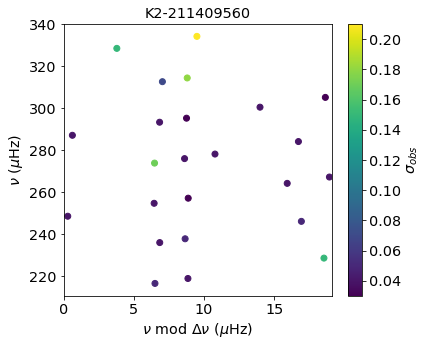

In [8]:
K2id = 211409560
#seismology
obsnumax = 272.2
obsnumax_e = 1.7
obsdnu = 19.10
obsdnu_e = 0.07
#spectroscopy
obsteff = 5030.3
obsteff_e = 40.0
obslogg = 3.556
obslogg_e = 0.05
obsfeh = 0.064
obsfeh_e = 0.002

obs_nu = df['obs_nu'][(df['K2id'] == K2id)]


obs_nu0 = df['obs_nu'][(df['K2id'] == K2id) & (df['obs_l'] == 0)].to_numpy()
obs_nu0_e = df['obs_nu_e'][(df['K2id'] == K2id) & (df['obs_l'] == 0)].to_numpy()
n0 = obs_nu0/obsdnu
print(n0)
print(obs_nu0,obs_nu0_e)


obs_nu1 = df['obs_nu'][(df['K2id'] == K2id) & (df['obs_l'] == 1)].to_numpy()
obs_nu1_e = df['obs_nu_e'][(df['K2id'] == K2id) & (df['obs_l'] == 1)].to_numpy()

obs_nu2 = df['obs_nu'][(df['K2id'] == K2id) & (df['obs_l'] == 2)].to_numpy()
obs_nu2_e = df['obs_nu_e'][(df['K2id'] == K2id) & (df['obs_l'] == 2)].to_numpy()

obs_nu = np.concatenate((obs_nu0, obs_nu1, obs_nu2))
obs_nu_e = np.concatenate((obs_nu0_e, obs_nu1_e, obs_nu2_e))

cp = plt.scatter((obs_nu % obsdnu), obs_nu, c = obs_nu_e, marker='o')
plt.title('K2-' + str(K2id))
plt.xlim([0.0, obsdnu])
plt.xlabel(r'$\nu$ mod $\Delta\nu$ ($\mu$Hz)')
plt.ylabel(r'$\nu$ ($\mu$Hz)')
cc = plt.colorbar(cp)
cc.set_label(r'$\sigma_{obs}$')



# load models with in a 5sigma ranges!

In [ ]:
files = glob.glob(datadr + "*.csv")

cc = ['initial_mass', 'initial_feh', 'initial_Z', 'initial_MLT',
      'initial_Yinit', 'initial_ov', 'model_number', 'star_age', 'star_mass',
      'effective_T', 'luminosity', 'radius', 'log_g'] + output_freq_header + output_E_header

temp = []
for filename in files:
    df0 = pd.read_csv(filename, index_col = 0)
    
    nuse = (
            (np.abs(df0.effective_T - obsteff) <= 5.0*obsteff_e)
            & (np.abs(df0.log_g - obslogg) <= 5.0*obslogg_e)
            ) 
    
    temp.append(df0[nuse][cc])
starset = pd.concat(temp, axis = 0, ignore_index = True)
starset


In [ ]:
#starset.to_csv(str(K2id) + '-1-5sigma-cut-short.csv')


In [9]:
starset = pd.read_csv(str(K2id) + '-1-5sigma-cut-short.csv')


In [10]:
starset['lk_effective_T'] = mle(starset['effective_T'], obs = obsteff, obs_e = obsteff_e)
starset['lk_log_g'] = mle(starset['log_g'], obs = obslogg, obs_e = obslogg_e)
starset['lk_spectro'] = starset['lk_effective_T']*starset['lk_log_g']
starset['lk_spectro'] = starset['lk_spectro']
starset['lk_total'] = starset['lk_spectro']

starset['lk_l0'] = starset['star_mass']*0.00
starset['dif_l0'] = starset['star_mass']*0.00 + 9999.0
starset['lk_l0_nsc'] = starset['star_mass']*0.00
starset['dif_l0_nsc'] = starset['star_mass']*0.00 + 9999.0
starset['surf_a1'] = starset['star_mass']*0.00 + 9999.0
starset['surf_a3'] = starset['star_mass']*0.00 + 9999.0

In [11]:
obs_n0 = np.full(len(obs_nu0), 0)
###check if obs_nu_0 is continuning
for i in range(1,len(obs_nu0)):
    diff = (obs_nu0[i] - obs_nu0[i-1])/obsdnu
    obs_n0[i] = obs_n0[i-1] + round(diff)
print(obs_nu0,obs_n0)

###fit radial modes
print('fitting radial modes phase 1')
starset = fit_radial_modes(starset, obs_nu0, obs_nu0_e, obs_n0, obsdnu,obsnumax, savefig = str(K2id) + '_sc1.png')
# Check sys offsets
sys = 10*np.min(starset['dif_l0'])
fobs_nu0_e = (obs_nu0_e**2.0 + sys**2.0)**0.5
print('fitting radial modes phase 2 with systematic uncertainty', sys)
starset = fit_radial_modes(starset, obs_nu0, fobs_nu0_e, obs_n0, obsdnu,obsnumax, savefig = str(K2id) + '_sc1.png')

[218.95 237.85 257.17 276.01 295.25 314.4  334.19] [0 1 2 3 4 5 6]
fitting radial modes phase 1
fitting radial modes phase 2 with systematic uncertainty 0.5953212455540324


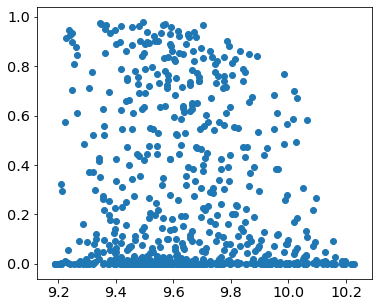

In [12]:
starset['lk_total'] = starset['lk_l0']/np.max(starset['lk_l0'])*starset['lk_effective_T']
starset['surf_a1'] = starset['surf_a1']*1.0e7
starset['surf_a3'] = starset['surf_a3']*1.0e7

sub = starset[(starset.lk_l0/starset.lk_l0.max()) >0.001]
sub.index = range(len(sub))
sub.to_csv(str(K2id) + '-2-radial_modes_fit.csv')

plt.scatter(np.log10(sub.star_age), sub.lk_total)

# Reload

In [132]:
starset = pd.read_csv(str(K2id) + '-2-radial_modes_fit.csv')

# fit l= 1 mixed modes

In [133]:
starset['lk_l0'] = starset['lk_l0']*0.0
starset['lk_l1'] = starset['lk_l0']*0.0
starset['lk_l2'] = starset['lk_l0']*0.0
starset['dif_l0'] = starset['dif_l0']*0.0
starset['dif_l1'] = starset['dif_l0']*0.0
starset['dif_l2'] = starset['dif_l0']*0.0

In [134]:
def fit_mixed_modes(starset, obs_nu0, obs_nu0_e, obs_nu1, obs_nu1_e, obs_nu2, obs_nu2_e):
    t = 0
    for index, row in starset.iterrows():
        t = t+1
        
        model_nu0 = row[nu_0_n_text]
        model_E0 = row[E_0_n_text]
        model_nu1 = row[nu_1_n_text]
        model_E1 = row[E_1_n_text]
        model_nu2 = row[nu_2_n_text]
        model_E2 = row[E_2_n_text]
        
        
        find_nu0, find_E0, lk0 = fit_two_sets(obs_nu0, obs_nu0_e, model_nu0, model_E0)
        find_nu1, find_E1, lk1 = fit_two_sets(obs_nu1, obs_nu1_e, model_nu1, model_E1)
        find_nu2, find_E2, lk2 = fit_two_sets(obs_nu2, obs_nu2_e, model_nu2, model_E2)

        obs_nu = np.concatenate((obs_nu0, obs_nu1, obs_nu2))   
        obs_nu_e = np.concatenate((obs_nu0_e, obs_nu1_e, obs_nu2_e))                                       
        find_nu = np.concatenate((find_nu0, find_nu1, find_nu2))
        find_E = np.concatenate((find_E0, find_E1, find_E2))
            
        a1, a3, find_nu_c = surface_correction(obs_nu, obs_nu_e, find_nu, find_E, obsnumax, 'bg2')
        starset.loc[index,'surf_a1'] = a1
        starset.loc[index,'surf_a3'] = a3        
                              
        tt0, tt1, chi2 = fit_two_sets(obs_nu, obs_nu_e, find_nu_c, find_E)
        
        nn0 = len(obs_nu0)
        nn1 = len(obs_nu1)  
        nn2 = len(obs_nu2)
    
        difs = np.abs(obs_nu - find_nu_c)
    
        starset.loc[index,'dif_l0'] = np.median( difs[0:(nn0)] )
        starset.loc[index,'dif_l1'] = np.median( difs[nn0:(nn0+nn1)])
        starset.loc[index,'dif_l2'] = np.median( difs[(nn0+nn1):(nn0+nn1+nn2)])
        
        starset.loc[index,'lk_l0'] = np.exp(-np.mean(chi2[0:(nn0)]))
        starset.loc[index,'lk_l1'] = np.exp(-np.mean(chi2[nn0:(nn0+nn1)]))
        starset.loc[index,'lk_l2'] = np.exp(-np.mean(chi2[(nn0+nn1):(nn0+nn1+nn2)]))
    return starset

def plot_mixed_modes(ax, starset, n, obs_nu0, obs_nu0_e, obs_nu1, obs_nu1_e):
    t = 0
    for index, row in starset.iterrows():
        t = t+1
        
        if t>n: break
        
        model_nu0 = row[nu_0_n_text]
        model_E0 = row[E_0_n_text]
        model_nu1 = row[nu_1_n_text]
        model_E1 = row[E_1_n_text]
        model_nu2 = row[nu_2_n_text]
        model_E2 = row[E_2_n_text]
        
        
        find_nu0, find_E0, lk0 = fit_two_sets(obs_nu0, obs_nu0_e, model_nu0, model_E0)
        find_nu1, find_E1, lk1 = fit_two_sets(obs_nu1, obs_nu1_e, model_nu1, model_E1)
        find_nu2, find_E2, lk2 = fit_two_sets(obs_nu2, obs_nu2_e, model_nu2, model_E2)

        obs_nu = np.concatenate((obs_nu0, obs_nu1, obs_nu2))   
        obs_nu_e = np.concatenate((obs_nu0_e, obs_nu1_e, obs_nu2_e))                                       
        find_nu = np.concatenate((find_nu0, find_nu1, find_nu2))
        find_E = np.concatenate((find_E0, find_E1, find_E2))
            
        a1, a3, find_nu_c = surface_correction(obs_nu, obs_nu_e, find_nu, find_E, obsnumax, 'bg2')
        
        nn0 = len(obs_nu0)
        nn1 = len(obs_nu1)  
        nn2 = len(obs_nu2)
        
        find_nu0_c = find_nu_c[0:(nn0)]
        find_nu1_c = find_nu_c[nn0:(nn0+nn1)]
        find_nu2_c = find_nu_c[(nn0+nn1):(nn0+nn1+nn2)]
        

        ax.scatter((obs_nu0 % obsdnu), obs_nu0, c = 'k',marker='o',s = 100)
        ax.scatter((obs_nu1 % obsdnu), obs_nu1, c = 'k',marker='^',s = 100)
        ax.scatter((obs_nu2 % obsdnu), obs_nu2, c = 'k',marker='s',s = 100)
        
        ax.scatter((find_nu0 % obsdnu), find_nu0, facecolors='none', edgecolors ='b',marker='o',s = 100)
        ax.scatter((find_nu1 % obsdnu), find_nu1, facecolors='none', edgecolors ='b',marker='^',s = 100)
        ax.scatter((find_nu2 % obsdnu), find_nu2, facecolors='none', edgecolors ='b',marker='s',s = 100) 

        ax.scatter((find_nu0_c % obsdnu), find_nu0_c, facecolors='none', edgecolors ='r',marker='o',s = 100)
        ax.scatter((find_nu1_c % obsdnu), find_nu1_c, facecolors='none', edgecolors ='r',marker='^',s = 100)
        ax.scatter((find_nu2_c % obsdnu), find_nu2_c, facecolors='none', edgecolors ='r',marker='s',s = 100)
    return

In [135]:
#nu_0_n_text  + nu_1_n_text + nu_2_n_text

print('fitting phase 1')

starset = fit_mixed_modes(starset, obs_nu0, obs_nu0_e, obs_nu1, obs_nu1_e, obs_nu2, obs_nu2_e)

        
####### check systematic and fit phase 2

sys_l0 = np.percentile((starset['dif_l0']), 10)
sys_l1 = np.percentile((starset['dif_l1']), 10)
sys_l2 = np.percentile((starset['dif_l2']), 10)

print('fitting phase 2 with sys', sys_l0, sys_l1, sys_l2)
    
fobs_nu0_e = (obs_nu0_e**2 + sys_l0**2)**0.5
fobs_nu1_e = (obs_nu1_e**2 + sys_l1**2)**0.5
fobs_nu2_e = (obs_nu2_e**2 + sys_l2**2)**0.5
    
starset = fit_mixed_modes(starset, obs_nu0, fobs_nu0_e, obs_nu1, fobs_nu1_e, obs_nu2, fobs_nu2_e)

fitting phase 1
fitting phase 2 with sys 0.1483949270995936 0.32931833483003176 0.114558358674401


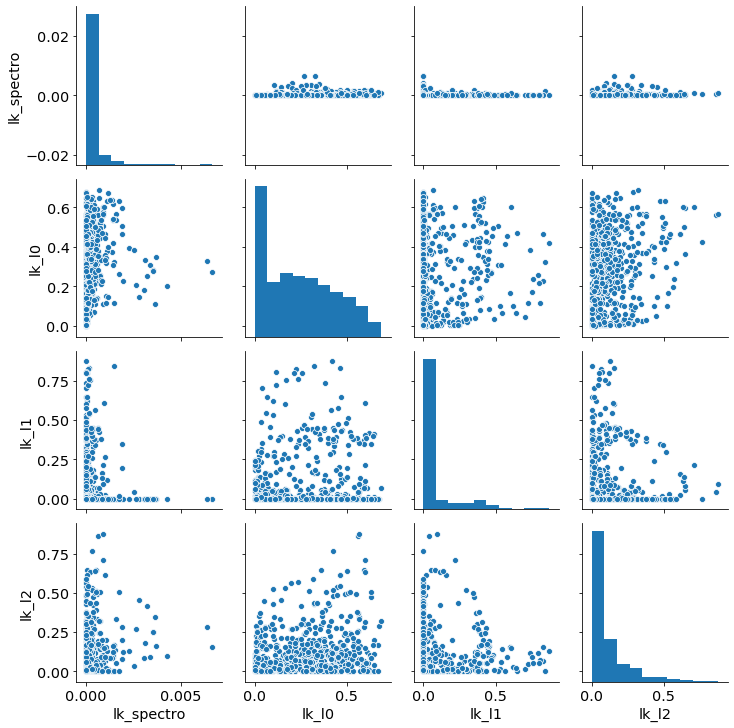

In [136]:
sns.pairplot(starset[['lk_spectro','lk_l0','lk_l1','lk_l2']])

In [137]:
starset['lk_total'] = starset['lk_l0']/np.max(starset['lk_l0'])*starset['lk_l1']/np.max(starset['lk_l1'])*starset['lk_l2']/np.max(starset['lk_l2'])
#starset['lk_total'] = starset['lk_l0']*starset['lk_l1']*starset['lk_l2']
starset['lk_total'] = starset['lk_total']/np.max(starset['lk_total'])

starset = starset[starset['lk_total']>=0.001]
starset = starset[starset['initial_Yinit']<=0.32]

starset['log_age'] = np.log10(starset['star_age'])
starset['surf_a1'] = starset['surf_a1']*1.0e7
starset['surf_a3'] = starset['surf_a3']*1.0e7

starset = starset.sort_values(by = 'lk_total', axis=0, ascending=False)
starset.index = range(len(starset))
starset.to_csv(str(K2id) + '-3-mixed_modes_fit.csv')


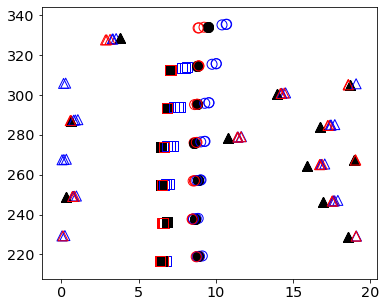

In [138]:
fig, ax = plt.subplots()
plot_mixed_modes(ax, starset, 3 ,obs_nu0, fobs_nu0_e, obs_nu1, fobs_nu1_e)

1.3599999999999999 1.46 1.2999999999999998
9.51 9.629999999999999 9.45
5047.5 5102.5 4942.5
3.3645 3.3735 3.3585


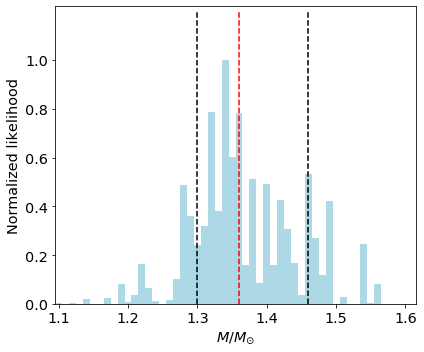

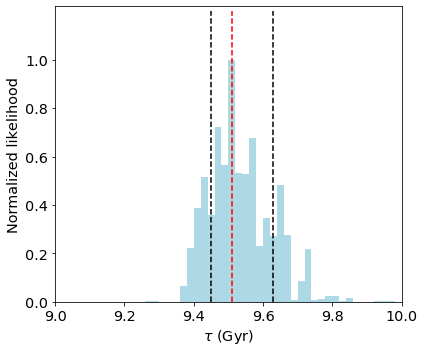

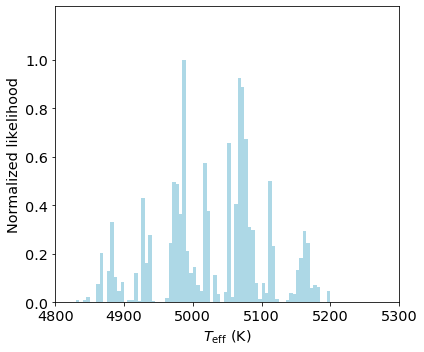

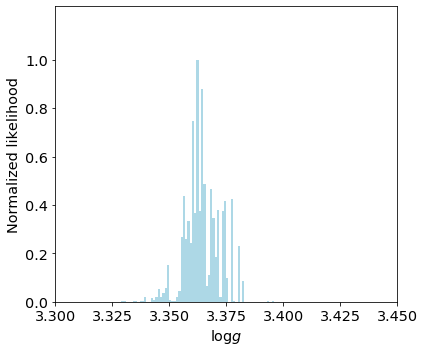

In [139]:
fig, ax = plt.subplots()    
smass, smass_ep, smass_em = prob_dist(starset, 'star_mass', 'lk_total', start = 1.095, end = 1.615, size = 0.01, ax = ax)
print(smass, smass_ep, smass_em)
ax.plot([smass,smass],[0,1200], 'r--')
ax.plot([smass_em,smass_em],[0,1200], 'k--')
ax.plot([smass_ep,smass_ep],[0,1200], 'k--')
ax.set_xlabel(r'$M/M_{\odot}$')
ax.set_ylabel('Normalized likelihood')
plt.tight_layout()
plt.savefig(str(K2id) + 'Estimate_mass.png')

fig, ax = plt.subplots()    
sage, sagep, sagem = prob_dist(starset, 'log_age', 'lk_total', start =9, end = 10, size = 0.02, ax = ax)
print(sage, sagep, sagem)
ax.plot([sage,sage],[0,1200], 'r--')
ax.plot([sagem,sagem],[0,1200], 'k--')
ax.plot([sagep,sagep],[0,1200], 'k--')
ax.set_xlabel(r'$\tau$ (Gyr)')
ax.set_ylabel('Normalized likelihood')
plt.tight_layout()
plt.savefig(str(K2id) + 'Estimate_age.png')

fig, ax = plt.subplots()    
slogg, sloggp, sloggm = prob_dist(starset, 'effective_T', 'lk_total', start = 4800, end = 5300, size = 5, ax = ax)
print(slogg, sloggp, sloggm)
ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel('Normalized likelihood')
plt.tight_layout()
plt.savefig(str(K2id) + 'Estimate_teff.png')

fig, ax = plt.subplots()    
slogg, sloggp, sloggm = prob_dist(starset, 'log_g', 'lk_total', start = 3.3, end = 3.45, size = 0.001, ax = ax)
print(slogg, sloggp, sloggm)
ax.set_xlabel(r'$\log g$')
ax.set_ylabel('Normalized likelihood')
plt.tight_layout()
plt.savefig(str(K2id) + 'Estimate_logg.png')
